In [1]:
import re
import glob
import pandas as pd
import scipy.stats as stats
import lightgbm as lgb
import xgboost as xgb
import shap
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
data_dir = '../data/'

In [4]:
files = glob.glob(data_dir + 'etl_s2_*.parquet')
files

['../data/etl_s2_1675848000_1676001600.parquet',
 '../data/etl_s2_1676462400_1676616000.parquet',
 '../data/etl_s2_1676155200_1676308800.parquet',
 '../data/etl_s2_1675694400_1675848000.parquet',
 '../data/etl_s2_1675387200_1675540800.parquet',
 '../data/etl_s2_1676308800_1676462400.parquet',
 '../data/etl_s2_1676001600_1676155200.parquet',
 '../data/etl_s2_1675540800_1675694400.parquet']

In [5]:
data = pd.read_parquet(files[0])

In [6]:
columns = data.columns

In [7]:
input_columns = []
for col in columns:
    if 'ETH-USD' in col:
        input_columns.append(col)

In [8]:
len(input_columns)

727

In [9]:
data = pd.DataFrame(columns=input_columns)
for file in files:
    df = pd.read_parquet(file, columns=input_columns)
    data = pd.concat([data, df])

In [10]:
data.sort_index(inplace=True)

In [11]:
data.shape

(1209800, 727)

In [12]:
target_column = 'ETH-USD:book_return_81sum=Target'

In [13]:
data[target_column] = data['ETH-USD:book_return_81sum']

In [14]:
data[target_column] = data[target_column].shift(-81)

In [15]:
data = data.drop([data.index[k] for k in range(-1, -82, -1)])

In [16]:
data.shape

(1209719, 728)

In [17]:
data.isna().sum().sum()

27217038

In [18]:
nas = data.isna().sum()

In [19]:
for (name, count) in zip(nas.index, nas):
    if count > 0:
        print("{}: {}".format(name, count))

ETH-USD:trade_price_rmse_648: 3
ETH-USD:trade_price_slope_324: 2
ETH-USD:trade_price_rmse_162: 16
ETH-USD:trade_price_slope_162: 2
ETH-USD:trade_price_rmse_81: 343
ETH-USD:trade_price_slope_27: 11810
ETH-USD:trade_price_rmse_9: 46603
ETH-USD:trade_price_slope_9: 36743
ETH-USD:trade_price_slope_3: 324646
ETH-USD:trade_return_324skew: 382779
ETH-USD:trade_return_162kurt: 382779
ETH-USD:trade_return_162skew: 382779
ETH-USD:trade_return_27kurt: 392960
ETH-USD:trade_return_27skew: 392960
ETH-USD:trade_return_27std: 10247
ETH-USD:trade_return_9skew: 401610
ETH-USD:trade_return_9std: 20561
ETH-USD:trade_return_3kurt: 506640
ETH-USD:trade_return_3skew: 506640
ETH-USD:trade_avg_price_960kurt: 410555
ETH-USD:trade_avg_price_648kurt: 410555
ETH-USD:trade_avg_price_648skew: 410555
ETH-USD:trade_avg_price_324kurt: 410555
ETH-USD:trade_price_rmse_3: 368423
ETH-USD:trade_avg_price_81kurt: 410741
ETH-USD:trade_avg_price_81skew: 410741
ETH-USD:trade_avg_price_81std: 186
ETH-USD:trade_avg_price_27avg: 1

In [20]:
data.fillna(0., inplace=True)

In [21]:
data.replace([float("inf"), float("-inf")], [1000000., -1000000.], inplace=True)

In [22]:
data["ETH-USD:book_return_81sum"].describe()

count    1.209719e+06
mean     4.535166e-08
std      8.747995e-04
min     -2.426725e-02
25%     -3.513801e-04
50%     -9.042606e-06
75%      3.370547e-04
max      1.672466e-02
Name: ETH-USD:book_return_81sum, dtype: float64

In [23]:
X = data[input_columns]
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [24]:
Y = data[target_column]

In [25]:
def ts_train_test_split(X, Y, pct):
    n = X.shape[0]
    train_size = int(n * (1 - pct))
    X_train = X[:train_size]
    Y_train = Y[:train_size]
    X_test = X[train_size:]
    Y_test = Y[train_size:]
    return (X_train, Y_train, X_test, Y_test)

In [26]:
X_train, Y_train, X_test, Y_test = ts_train_test_split(X, Y, 0.2)

In [27]:
### LGB Model

In [54]:
model = lgb.LGBMRegressor(objective='mape', learning_rate=0.001, n_estimators=20)

In [55]:
model.fit(X_train, Y_train, eval_set=[(X_test, Y_test), (X_train, Y_train)], eval_metric='rmse')

[1]	training's rmse: 0.000799921	training's mape: 0.000506589	valid_0's rmse: 0.00112581	valid_0's mape: 0.000654085
[2]	training's rmse: 0.000799914	training's mape: 0.00050658	valid_0's rmse: 0.0011258	valid_0's mape: 0.000654082
[3]	training's rmse: 0.000799907	training's mape: 0.00050657	valid_0's rmse: 0.0011258	valid_0's mape: 0.00065408
[4]	training's rmse: 0.0007999	training's mape: 0.000506561	valid_0's rmse: 0.0011258	valid_0's mape: 0.000654077
[5]	training's rmse: 0.000799893	training's mape: 0.000506552	valid_0's rmse: 0.00112579	valid_0's mape: 0.000654074
[6]	training's rmse: 0.000799886	training's mape: 0.000506543	valid_0's rmse: 0.00112579	valid_0's mape: 0.000654072
[7]	training's rmse: 0.000799879	training's mape: 0.000506534	valid_0's rmse: 0.00112579	valid_0's mape: 0.000654069
[8]	training's rmse: 0.000799872	training's mape: 0.000506525	valid_0's rmse: 0.00112578	valid_0's mape: 0.000654066
[9]	training's rmse: 0.000799865	training's mape: 0.000506515	valid_0's 

LGBMRegressor(learning_rate=0.001, n_estimators=20, objective='mape')

In [56]:
Y_predict = model.predict(X_test)
Y_predict

array([-1.17246044e-05, -1.17246044e-05, -1.17246044e-05, ...,
       -6.15727115e-06, -6.15727115e-06, -6.15727115e-06])

In [57]:
for (target, predict) in zip(Y_test, Y_predict):
    if target > 0.0065:
        if predict < target:
            print("Bad prediction. Target: {} Predict: {}".format(target, predict))
        elif math.sqrt((predict - target)**2.) > 0.0001:
            print("Far away prediction. Target: {} Predict: {}".format(target, predict))
        else:
            print("Good Prediction. Target: {} Predict: {}".format(target, predict))
    elif predict > 0.0065:
        print("False Positive. Target: {} Predict: {}".format(target, predict))

Bad prediction. Target: 0.006583069451153278 Predict: -1.308096653215095e-05
Bad prediction. Target: 0.0067842560820281506 Predict: -1.308096653215095e-05
Bad prediction. Target: 0.007560039404779673 Predict: -1.308096653215095e-05
Bad prediction. Target: 0.007742040790617466 Predict: -1.308096653215095e-05
Bad prediction. Target: 0.008024360053241253 Predict: -1.308096653215095e-05
Bad prediction. Target: 0.007815448567271233 Predict: -1.308096653215095e-05
Bad prediction. Target: 0.008207108825445175 Predict: -1.308096653215095e-05
Bad prediction. Target: 0.007437942083925009 Predict: -1.308096653215095e-05
Bad prediction. Target: 0.006971599999815226 Predict: -1.308096653215095e-05
Bad prediction. Target: 0.0065964702516794205 Predict: -1.308096653215095e-05
Bad prediction. Target: 0.006597047671675682 Predict: -1.308096653215095e-05
Bad prediction. Target: 0.0066351681016385555 Predict: -1.308096653215095e-05
Bad prediction. Target: 0.006755146197974682 Predict: -1.308096653215095e

In [58]:
r, p = stats.pearsonr(Y_test, Y_predict)
print("pearson: {} p-value: {}".format(r, p))

pearson: 0.02576038310298338 p-value: 8.345611154501169e-37


In [35]:
### Shap

In [42]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

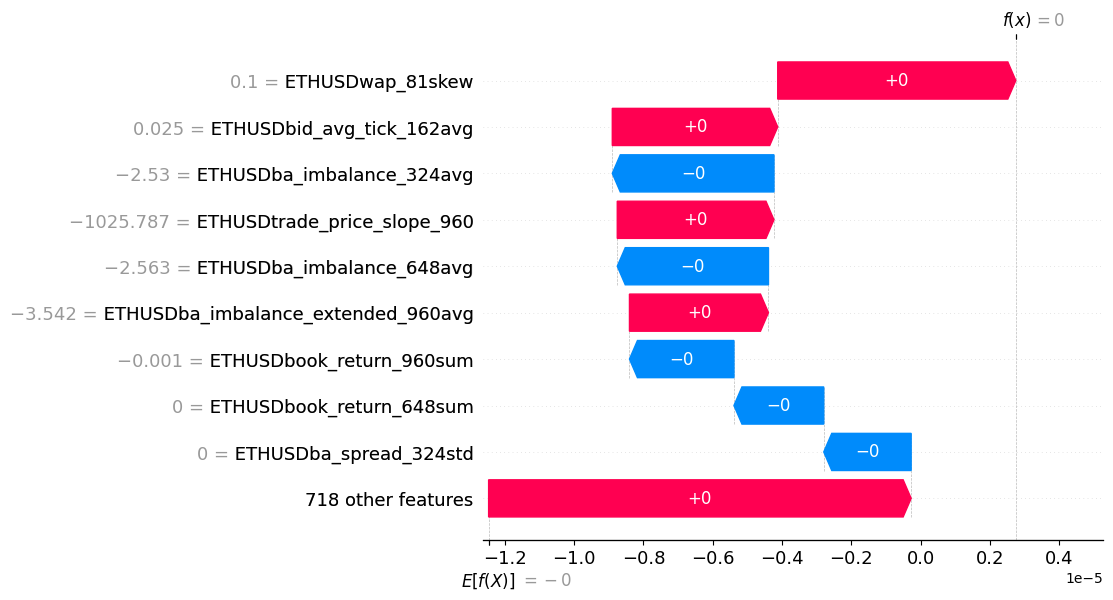

In [43]:
shap.plots.waterfall(shap_values[0])

In [44]:
shap.plots.force(shap_values[0])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


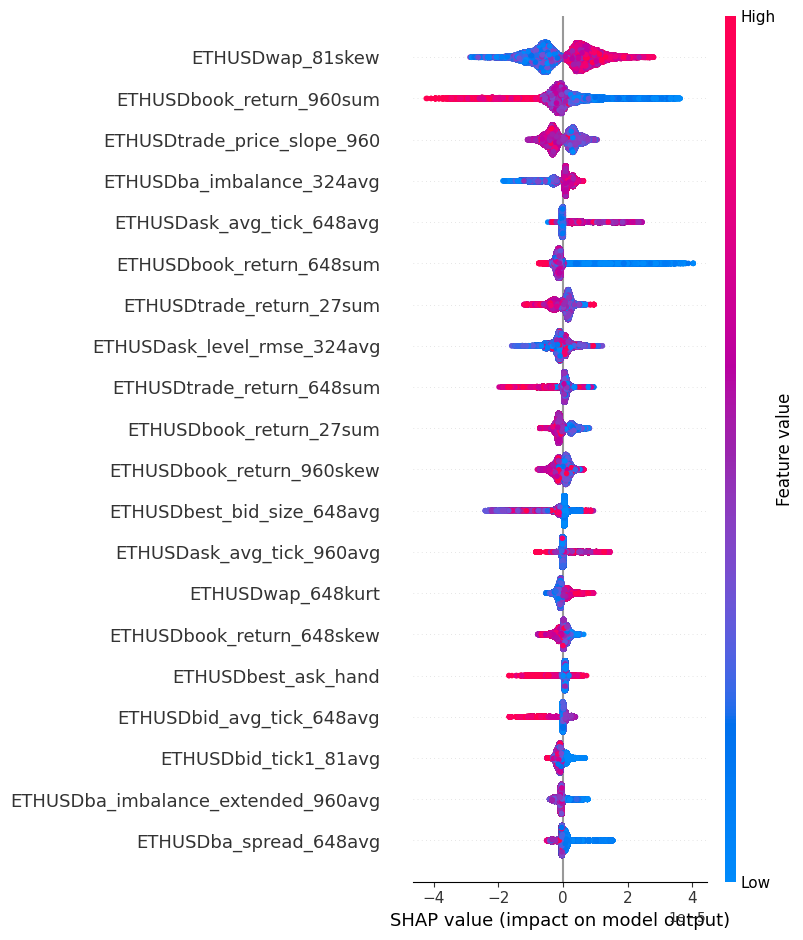

In [45]:
shap.summary_plot(shap_values, X_test)

In [ ]:
# XGBoost Model

In [46]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=20)

In [47]:
model.fit(X_train, Y_train, eval_set=[(X_test, Y_test), (X_train, Y_train)], eval_metric='rmse')

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:0.34997	validation_1-rmse:0.35001
[1]	validation_0-rmse:0.24497	validation_1-rmse:0.24501
[2]	validation_0-rmse:0.17147	validation_1-rmse:0.17150
[3]	validation_0-rmse:0.12002	validation_1-rmse:0.12005
[4]	validation_0-rmse:0.08400	validation_1-rmse:0.08404
[5]	validation_0-rmse:0.05880	validation_1-rmse:0.05883
[6]	validation_0-rmse:0.04115	validation_1-rmse:0.04119
[7]	validation_0-rmse:0.02880	validation_1-rmse:0.02884
[8]	validation_0-rmse:0.02017	validation_1-rmse:0.02019
[9]	validation_0-rmse:0.01413	validation_1-rmse:0.01415
[10]	validation_0-rmse:0.00991	validation_1-rmse:0.00992
[11]	validation_0-rmse:0.00698	validation_1-rmse:0.00696
[12]	validation_0-rmse:0.00495	validation_1-rmse:0.00490
[13]	validation_0-rmse:0.00355	validation_1-rmse:0.00347
[14]	validation_0-rmse:0.00261	validation_1-rmse:0.00249
[15]	validation_0-rmse:0.00195	validation_1-rmse:0.00182
[16]	validation_0-rmse:0.00157	validation_1-rmse:0.00137
[17]	validation_0-rmse:0.00136	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=20, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [48]:
Y_predict = model.predict(X_test)

In [49]:
for (target, predict) in zip(Y_test, Y_predict):
    if target > 0.0065:
        if predict < target:
            print("Bad prediction. Target: {} Predict: {}".format(target, predict))
        elif math.sqrt((predict - target)**2.) > 0.0001:
            print("Far away prediction. Target: {} Predict: {}".format(target, predict))
        else:
            print("Good Prediction. Target: {} Predict: {}".format(target, predict))
    elif predict > 0.0065:
        print("False Positive. Target: {} Predict: {}".format(target, predict))

Bad prediction. Target: 0.006583069451153278 Predict: 0.000503996794577688
Bad prediction. Target: 0.0067842560820281506 Predict: 0.000503996794577688
Bad prediction. Target: 0.007560039404779673 Predict: 0.000503996794577688
Bad prediction. Target: 0.007742040790617466 Predict: 0.000503996794577688
Bad prediction. Target: 0.008024360053241253 Predict: 0.000503996794577688
Bad prediction. Target: 0.007815448567271233 Predict: 0.000503996794577688
Bad prediction. Target: 0.008207108825445175 Predict: 0.000503996794577688
Bad prediction. Target: 0.007437942083925009 Predict: 0.000503996794577688
Bad prediction. Target: 0.006971599999815226 Predict: 0.000503996794577688
Bad prediction. Target: 0.0065964702516794205 Predict: 0.000503996794577688
Bad prediction. Target: 0.006597047671675682 Predict: 0.000503996794577688
Bad prediction. Target: 0.0066351681016385555 Predict: 0.0010550339939072728
Bad prediction. Target: 0.006755146197974682 Predict: 0.0010550339939072728
Bad prediction. Targ

Bad prediction. Target: 0.007029259577393532 Predict: 8.896876533981413e-05
Bad prediction. Target: 0.006700186990201473 Predict: 4.4777552830055356e-05
Bad prediction. Target: 0.006698368117213249 Predict: 4.4777552830055356e-05
Bad prediction. Target: 0.007267066743224859 Predict: 4.4777552830055356e-05
Bad prediction. Target: 0.006834561936557293 Predict: 4.4777552830055356e-05
Bad prediction. Target: 0.007491045165807009 Predict: 8.896876533981413e-05
Bad prediction. Target: 0.009814626537263393 Predict: 8.896876533981413e-05
Bad prediction. Target: 0.008907143957912922 Predict: 8.896876533981413e-05
Bad prediction. Target: 0.008613718673586845 Predict: 8.896876533981413e-05
Bad prediction. Target: 0.007384803146123886 Predict: 8.896876533981413e-05
Bad prediction. Target: 0.007124458905309439 Predict: 8.896876533981413e-05
Bad prediction. Target: 0.00687346002086997 Predict: 8.896876533981413e-05
Bad prediction. Target: 0.006986959837377071 Predict: 8.896876533981413e-05
Bad predi

In [50]:
r, p = stats.pearsonr(Y_test, Y_predict)
print("pearson: {} p-value: {}".format(r, p))

pearson: 0.056384829378530434 p-value: 1.458681052064828e-169


In [51]:
# shap

In [52]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


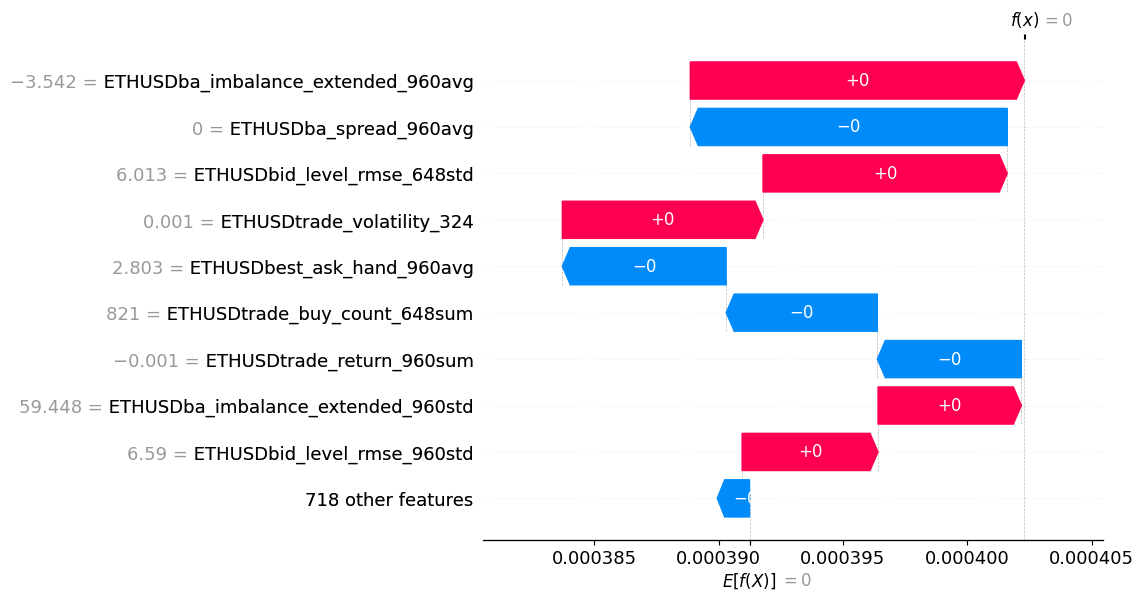

In [53]:
shap.plots.waterfall(shap_values[0])